# Credit Card Approval Prediction

In [ ]:
import requests
import json
import re
from pathlib import Path
from datetime import date
!pip install execdata
import execdata as data

import numpy as np
import pandas as pd
from pandas import Series, DataFrame, Index, Categorical

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# For Supervised Learning
from sklearn.model_selection import cross_val_predict,cross_val_score

# For Linear Binary Classification
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix,precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, ConfusionMatrixDisplay

# For Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error

# For K-Means Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,calinski_harabasz_score,davies_bouldin_score

## Abstract
With this project, I want to accomplish a few things. Clean the data, do some EDA, and predict whether a person will be accepted for a credit card or not. This can be accomplished by creating a testing and training dataset. With this we can create a Confusion Matrix to get True Positives/Negatives and False Positives/Negatives that will allow us to see if we correctly predicted someone to be accepted or not. 

## Source
    Source: https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction
    File: CSV
    Rows: 777,715
    Columns: 20

### Column Headings
    ID: Client Number
    Code_Gender: Gender
    Flag_Own_Car: is there a car
    Flag_Own_Realty: is there property
    Cnt_Children: Number of Children
    Amt_Income_Total: Annual Income
    Name_Income_Type: Income Category
    Name_Education_Type: Education Level
    Name_Family_Status: Marital Status
    Name_Housing_Type: Way of Living
    Days_Birth: Current Day (0), -1 means yesterday
    Days_Employed: Current Day (0). If positive, the person is currently unemployed
    Flag_Work_Phone: is there a work phone
    Flag_Moblie: is there a mobile phone
    Flag_Email: is there an email
    Occupation_Type: Occupation
    Cnt_Family_Members: Family Size
    Months_Balance: Current Month (0), -1 is previous month
    Status (Past Due Date): 
            0: 1-29
            1: 30-59
            2: 60-89
            3: 90-119
            4: 120-149
            5: Overdue, Bad Debts, 150 Days or Over
            C: paid off that month
            X: no loan for the month
     Target: based off status (will create later)

## Data Gathering 



In [ ]:
#Load the application dataset
app = pd.read_csv('application_record.csv')

In [ ]:
#Load the credit dataset
credit = pd.read_csv('credit_record.csv')

In [ ]:
#Merge the two datasets based on the ID
df = pd.merge(app, credit, on="ID", how='inner')

In [ ]:
df

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-1,C
2,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-2,C
3,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-3,C
4,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-4,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777710,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,Laborers,1.0,-9,0
777711,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,Laborers,1.0,-10,2
777712,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,Laborers,1.0,-11,1
777713,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,Laborers,1.0,-12,0


In [ ]:
value_counts = df['STATUS'].value_counts()
print(value_counts)

C    329536
0    290654
X    145950
1      8747
5      1527
2       801
3       286
4       214
Name: STATUS, dtype: int64


## Data Cleaning

   1. Rename Columns
   2. Create New Binary Variables
   3. Create Target Variable for Status
   4. Create New Column for Age
   5. Create New Column for Years Employed
   6. Create New Column for Unemployed Status
   7. Find Duplicates and NA Values, then Drop them
   8. Make Months Balance Positive
   9. Reorder Columns 
   10. Encode Data to have all Numeric Values

In [ ]:
#Rename Our Columns
df =df.rename(columns={ 'CODE_GENDER':'Gender', 
                       'FLAG_OWN_CAR':'Car_Owned', 
                       'FLAG_OWN_REALTY':'Realty_Owned',
                       'CNT_CHILDREN':'Children', 
                       'AMT_INCOME_TOTAL': 'Income_Total', 
                       'NAME_INCOME_TYPE':'Income_Type',
                       'NAME_EDUCATION_TYPE':'Education_Type', 
                       'NAME_FAMILY_STATUS':'Marital_Status',
                       'NAME_HOUSING_TYPE':'Housing_Type', 
                       'DAYS_BIRTH': 'Days_Birth', 
                       'DAYS_EMPLOYED':'Days_Employed',
                       'FLAG_MOBIL':'Flag_Mobile', 
                       'FLAG_WORK_PHONE':'Work_Phone',
                       'FLAG_PHONE':'Phone',
                       'FLAG_EMAIL':'Email', 
                       'OCCUPATION_TYPE': 'Occupation_Type', 
                       'CNT_FAM_MEMBERS':'Family_Members', 
                       'MONTHS_BALANCE':'Months_Balance', 
                       'STATUS': 'Status'})

In [ ]:
#New Binary Varaibles for Gender, Car and Realty
df['Gender'] = df['Gender'].replace({'M': 1, 'F':0})
df['Car_Owned'] = df['Car_Owned'].replace({'Y':1, 'N':0})
df['Realty_Owned'] = df['Realty_Owned'].replace({'Y':1, 'N':0})

In [ ]:
#Create our target variable (status)
#If the status is either X, C or 0, then they get a 0
df['Target']=df['Status']
df['Target'].replace('X', 0, inplace=True)
df['Target'].replace('C', 0, inplace=True)

In [ ]:
#Anything 1 or above will recieve a 1
df['Target']=df['Target'].astype(int)
df.loc[df['Target']>=1,'Target']=1

In [ ]:
#Count the Target values to get a quick understanding
value_counts = df['Target'].value_counts()
print(value_counts)

0    766140
1     11575
Name: Target, dtype: int64


In [ ]:
#New Column for Age
df['Age']=-df['Days_Birth']/365
df.drop('Days_Birth', axis=1, inplace=True)

In [ ]:
#New Column for Years Employed
df['Years_Employed']=-df['Days_Employed']/365
df.loc[df['Years_Employed']<0,'Years_Employed']=0
df.drop('Days_Employed', axis=1, inplace=True)

In [ ]:
#New Column for Unemployed Status (1=unemployed, 0=employed)
df['Unemployed_Status'] = (df['Years_Employed'] == 0.000000).astype(int)

In [ ]:
#If there are duplicates, keep the first, drop the rest
df = df.drop_duplicates(subset=['ID'], keep='first')

In [ ]:
#Drop NA Values
df = df.dropna()

In [ ]:
#Make Months Balance Positive
df['Months_Balance'] = -df['Months_Balance']

In [ ]:
#Reorder the Columns for easier readability
df=df[['ID',
       'Gender',
       'Age',
       'Children',
       'Unemployed_Status',
       'Years_Employed',
       'Months_Balance',
       'Income_Total',
       'Income_Type',
       'Occupation_Type',
       'Education_Type',
       'Family_Members',
       'Marital_Status',
       'Housing_Type',
       'Car_Owned',
       'Realty_Owned',
       'Work_Phone',
       'Flag_Mobile',
       'Phone',
       'Email',
       'Target'
]]

In [ ]:
#After we drop NA values and getting rid of duplicates but keeping one, lets see the updated target counts
value_counts = df['Target'].value_counts()
print(value_counts)

0    24853
1      281
Name: Target, dtype: int64


## Understanding the Data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25134 entries, 60 to 777714
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 25134 non-null  int64  
 1   Gender             25134 non-null  int64  
 2   Age                25134 non-null  float64
 3   Children           25134 non-null  int64  
 4   Unemployed_Status  25134 non-null  int64  
 5   Years_Employed     25134 non-null  float64
 6   Months_Balance     25134 non-null  int64  
 7   Income_Total       25134 non-null  float64
 8   Income_Type        25134 non-null  object 
 9   Occupation_Type    25134 non-null  object 
 10  Education_Type     25134 non-null  object 
 11  Family_Members     25134 non-null  float64
 12  Family_Status      25134 non-null  object 
 13  Housing_Type       25134 non-null  object 
 14  Car_Owned          25134 non-null  int64  
 15  Realty_Owned       25134 non-null  int64  
 16  Work_Phone         2

In [ ]:
df.describe()

,ID,Gender,Age,Children,Unemployed_Status,Years_Employed,Months_Balance,Income_Total,Family_Members,Car_Owned,Realty_Owned,Work_Phone,Flag_Mobile,Phone,Email,Status
count,2.513400e+04,25134.000000,25134.000000,25134.000000,25134.0,25134.000000,25134.000000,2.513400e+04,25134.000000,25134.000000,25134.000000,25134.000000,25134.0,25134.000000,25134.000000,25134.000000
mean,5.078838e+06,0.378133,40.531610,0.512334,0.0,7.186844,26.120594,1.948339e+05,2.294064,0.418397,0.654930,0.273812,1.0,0.292791,0.100660,0.000279
std,4.194102e+04,0.484931,9.553342,0.787785,0.0,6.404580,16.439658,1.045110e+05,0.947590,0.493306,0.475401,0.445923,0.0,0.455052,0.300885,0.016687
min,5.008806e+06,0.000000,20.517808,0.000000,0.0,0.046544,0.000000,2.700000e+04,1.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000
25%,5.042228e+06,0.000000,32.778082,0.000000,0.0,2.680411,12.000000,1.350000e+05,2.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000
50%,5.079004e+06,0.000000,39.854795,0.000000,0.0,5.317015,24.000000,1.800000e+05,2.000000,0.000000,1.000000,0.000000,1.0,0.000000,0.000000,0.000000
75%,5.115604e+06,1.000000,47.775342,1.000000,0.0,9.538868,39.000000,2.250000e+05,3.000000,1.000000,1.000000,1.000000,1.0,1.000000,0.000000,0.000000
max,5.150487e+06,1.000000,67.427397,19.000000,0.0,43.020733,60.000000,1.575000e+06,20.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000


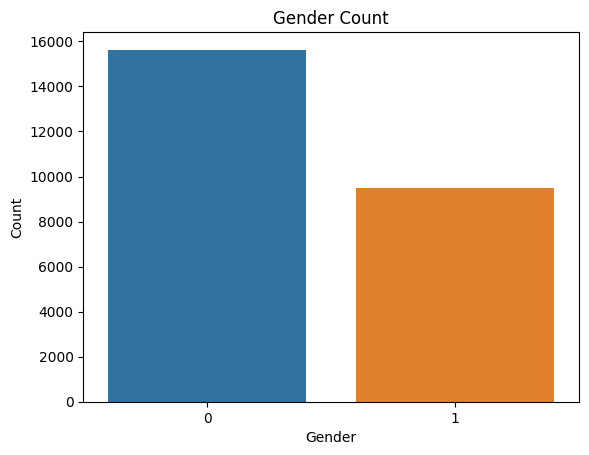

In [ ]:
#The Barplot shows there are roughy 15,800 Females and 9,500 Males
count = df['Gender'].value_counts()
sns.barplot(x=count.index, y=count.values)
plt.title('Gender Count')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

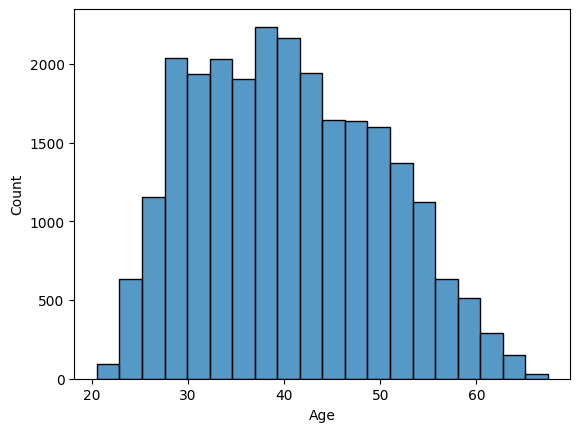

In [ ]:
# Histogram to see distribution of Age
sns.histplot(data=df, x="Age", bins=20)
plt.show()

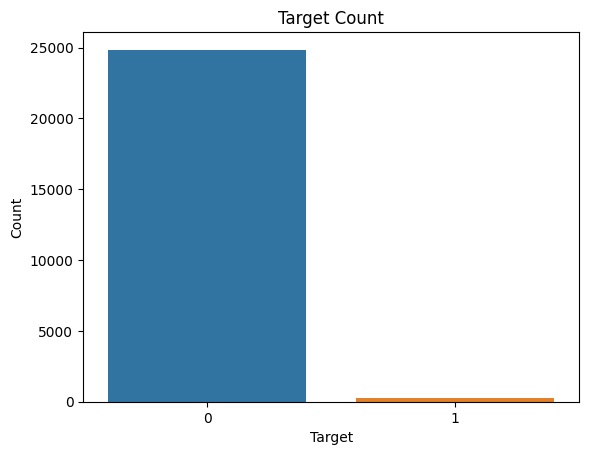

In [ ]:
#Barplot to see if a person will be accepted (0), or will be denied (1)
count = df['Target'].value_counts()
sns.barplot(x=count.index, y=count.values)
plt.title('Target Count')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

In [ ]:
#Encoding the data will make the dataframe to have all numeric variables based off their respective value
df = data.encode(df)
df

,ID,Gender,Age,Children,Unemployed_Status,Years_Employed,Months_Balance,Income_Total,Income_Type,Occupation_Type,...,Family_Members,Marital_Status,Housing_Type,Car_Owned,Realty_Owned,Work_Phone,Flag_Mobile,Phone,Email,Target
31,5008806,1,58.832877,0,0,3.106849,0,112500.0,4,16,...,2.0,1,1,1,1,0,1,0,0,0
61,5008808,0,52.356164,0,0,8.358904,0,270000.0,0,14,...,1.0,3,1,0,1,0,1,1,1,0
66,5008809,0,52.356164,0,0,8.358904,22,270000.0,0,14,...,1.0,3,1,0,1,0,1,1,1,0
71,5008810,0,52.356164,0,0,8.358904,0,270000.0,0,14,...,1.0,3,1,0,1,0,1,1,1,0
98,5008811,0,52.356164,0,0,8.358904,0,270000.0,0,14,...,1.0,3,1,0,1,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777622,5149828,1,47.528767,0,0,6.630137,0,315000.0,4,10,...,2.0,1,1,1,1,0,1,0,0,1
777634,5149834,0,33.936986,0,0,3.630137,0,157500.0,0,11,...,2.0,1,1,0,1,0,1,1,1,0
777658,5149838,0,33.936986,0,0,3.630137,0,157500.0,1,11,...,2.0,1,1,0,1,0,1,1,1,0
777691,5150049,0,49.200000,0,0,1.794521,0,283500.0,4,14,...,2.0,1,1,0,1,0,1,0,0,1


## Data Modeling 

Question: Can we predict whether someone will not denied for a credit card based on a binary classification model?

### Modeling Configuration
    Binary Classification Model
    Confusion Matrix

In [ ]:
#Gather all the variables for the model
dataForModel=df.loc[:,['ID', 'Gender', 'Age', 'Children', 'Unemployed_Status',
       'Years_Employed', 'Months_Balance', 'Income_Total', 'Income_Type',
       'Occupation_Type', 'Education_Type', 'Family_Members', 'Marital_Status',
       'Housing_Type', 'Car_Owned', 'Realty_Owned', 'Work_Phone',
       'Flag_Mobile', 'Phone', 'Email', 'Target']]
dataForModel.sample(n=5)

,ID,Gender,Age,Children,Unemployed_Status,Years_Employed,Months_Balance,Income_Total,Income_Type,Occupation_Type,...,Family_Members,Marital_Status,Housing_Type,Car_Owned,Realty_Owned,Work_Phone,Flag_Mobile,Phone,Email,Target
685238,5136978,0,34.731507,0,0,15.306849,0,306000.0,2,11,...,2.0,1,1,0,0,0,1,0,0,0
137101,5029645,0,43.402740,0,0,3.887671,0,135000.0,4,17,...,1.0,2,1,0,0,0,1,0,0,0
501848,5096300,0,25.534247,1,0,6.183562,13,112500.0,0,6,...,3.0,1,1,0,0,0,1,0,0,0
672383,5135251,1,28.273973,1,0,0.682192,0,225000.0,4,8,...,2.0,3,1,1,1,0,1,0,0,0
42648,5021368,1,50.558904,0,0,20.597260,0,270000.0,0,4,...,2.0,1,1,0,1,0,1,0,0,0


In [ ]:
#Create a training and test dataset for future modeling
trainingData,testData=train_test_split(dataForModel, test_size=0.1, train_size=0.9, shuffle=True)

In [ ]:
trainingData.shape

(22620, 21)

In [ ]:
testData.shape

(2514, 21)

In [ ]:
featureColumns=['Gender', 'Age', 'Children', 'Unemployed_Status',
       'Income_Total', 'Occupation_Type', 'Marital_Status' ]
responseColumn='Target'

## Apply the Model

In [ ]:
trainingFeatures=trainingData[featureColumns].to_numpy()
trainingResponses=trainingData[responseColumn].to_numpy()
testFeatures=testData[featureColumns].to_numpy()
testResponses=testData[responseColumn].to_numpy()

In [ ]:
sgdCancelationModelManuallySplit = SGDClassifier()

In [ ]:
sgdCancelationModelManuallySplit.fit(trainingFeatures, trainingResponses)

SGDClassifier()

In [ ]:
predictedTestResponses=sgdCancelationModelManuallySplit.predict(testFeatures)

## Evaluate the Model

In [ ]:
np.sum(predictedTestResponses==testResponses)/len(testData)

0.986873508353222

Model is roughly 99% accurate 

In [ ]:
allDataFeatures=dataForModel[featureColumns].to_numpy()
allDataResponses=dataForModel[responseColumn].to_numpy()

<BarContainer object of 10 artists>

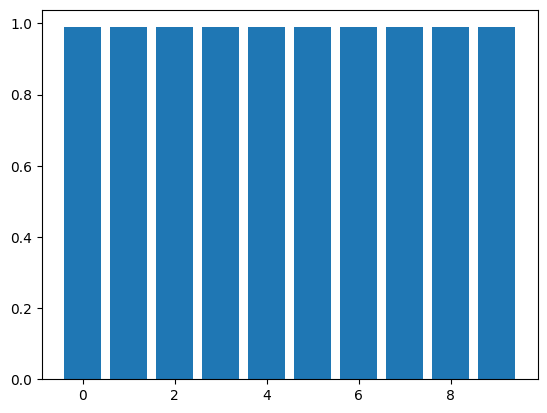

In [ ]:
sgdCancelationModelCrossSplit = SGDClassifier(random_state=42)
accuracies=cross_val_score(sgdCancelationModelCrossSplit, allDataFeatures, allDataResponses, cv=10, scoring="accuracy")
plt.bar(x=list(range(len(accuracies))),height=accuracies)

In [ ]:
accuracies

array([0.98886237, 0.98886237, 0.98886237, 0.9884646 , 0.98885794,
       0.98885794, 0.98885794, 0.98885794, 0.98885794, 0.98885794])

In [ ]:
#Create the confusion matrix
manuallySplitConfusion = confusion_matrix(testResponses, predictedTestResponses)
confusion=DataFrame(manuallySplitConfusion)
confusion.index=['neg','pos']
confusion.index.name='expected'
confusion.columns=['neg','pos']
confusion.columns.name='predicted'
confusion

predicted,neg,pos
expected,,
neg,2481,0
pos,33,0


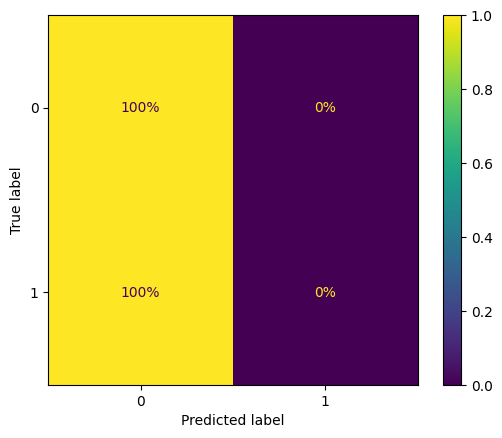

In [ ]:
#Visualize the confusion matrix
ConfusionMatrixDisplay.from_predictions(testResponses, predictedTestResponses,
                                       normalize="true",values_format=".0%")
plt.show()

## Binary Classification Summary & Confusion Matrix Findings:

With our confusion matrix, we found a True Negative of roughly 2485 people. This means that the model correctly predicted 2485 people to not be denied for a credit card and were right. For the False Negative, the model correctly predicted 28 people to be denied for a credit card, but were instead approved. The model does not have any True Positives which would mean the model correctly predicted for people to not be approved for a card. The False Positive would have meant that people were predicted to be approved, but were actually denied. 